In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function




Populating the interactive namespace from numpy and matplotlib


In [2]:
#define functions

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
                     


In [25]:
def process_sample(dir_trail,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]

    for i in range(len(allfname_trail)):
        R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
        phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
        z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
        
    for ii in range(len(allfname_lead)):
        R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
        phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
        z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True) 
    
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
    else : 
        print ("acceptable output format : radec or xieta")
        

def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,fname=''):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    shot_noise=numpy.sqrt(Ndn)
    err=shot_noise/(N*bw)
    
    pp= Polynomial.fit(midxi,Ndn,deg=polydeg,w=1/err)
    nden=Ndn/pp(np.array(midxi))
        
    if plot :
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.plot(midxi,Ndn,ls='steps-mid')
            plt.errorbar(midxi,Ndn,err,marker='None',ls='None')
            plt.plot(midxi,pp(np.array(midxi)),c='r',label=r'$3^{\rm{rd}}$ order polynomial')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('Star count',fontsize=18)
            plt.legend(loc='upper right',fontsize=18)
    
            plt.subplot(1,2,2)
            plt.plot(midxi,nden,ls='steps-mid')
            plt.errorbar(midxi,nden,err,marker='None',ls='None')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('normalized star count',fontsize=18)
            
            if fname != '' :
                plt.savefig(fname)
            
            plt.show()
            
    return (midxi,nden,err)
  

In [4]:
dir35='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/trailing/'
ra_t, dec_t,ra_l,dec_l=process_sample(dir35,out_format='radec')
xi_t,eta_t,xi_l,eta_l=process_sample(dir35,out_format='xieta')

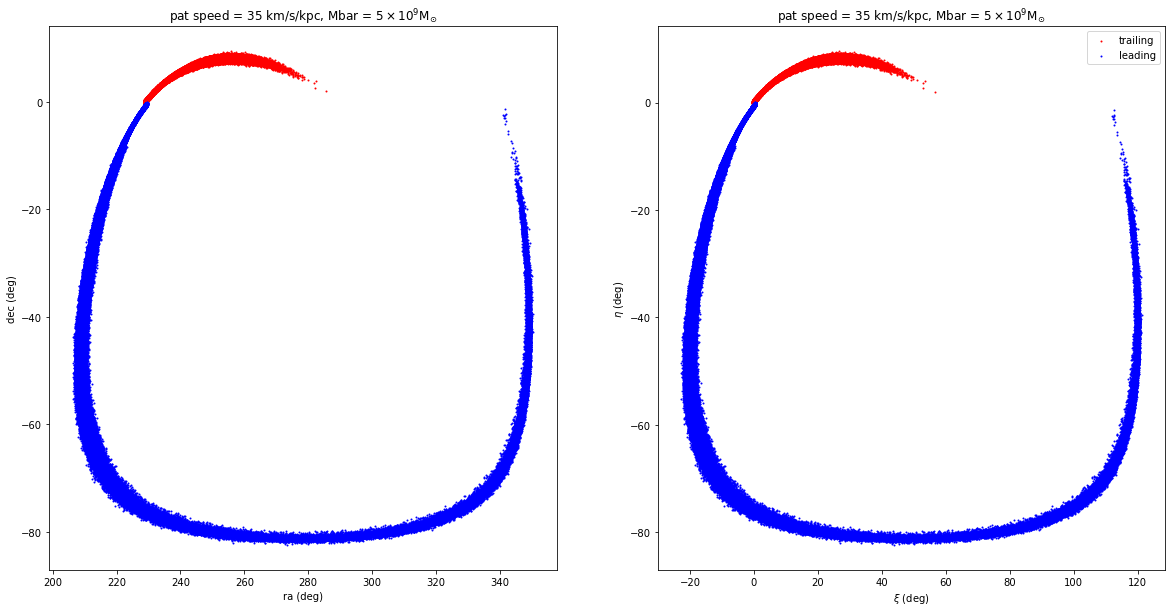

In [12]:
#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t,dec_t,s=1,c='r',label='trailing')
plt.scatter(ra_l,dec_l,s=1,c='b',label='leading',alpha=1.)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $5\times 10^{9} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing')
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $5\times 10^{9} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('plots/5_109Msun_sky_coords.pdf',format='pdf',dpi=10)
plt.show()



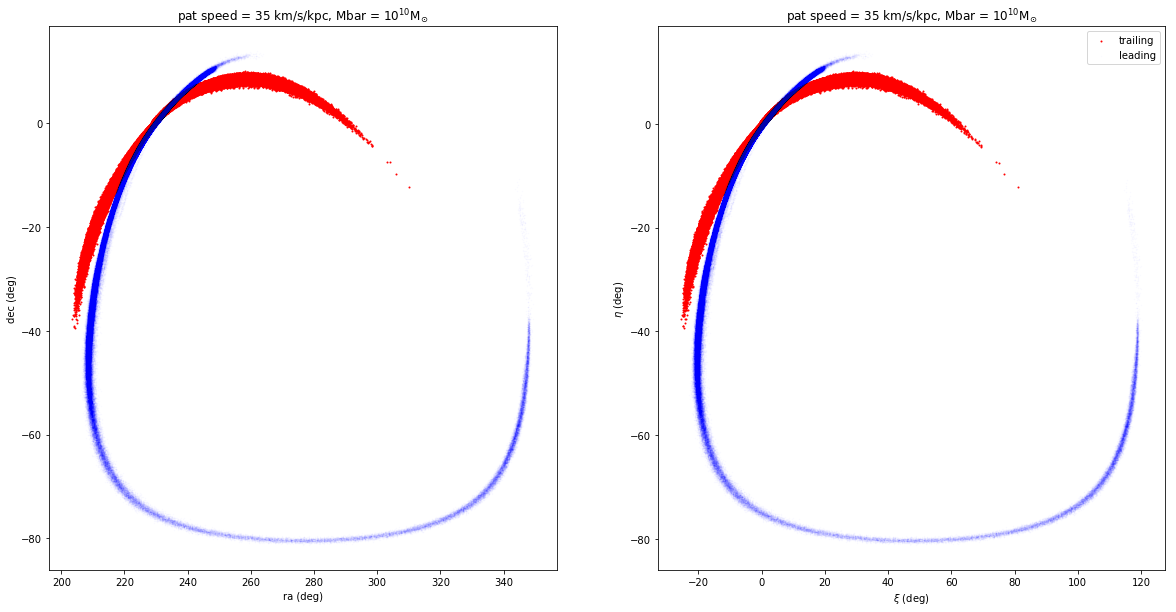

In [13]:
dir35_1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir35_1,out_format='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir35_1,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing')
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading',alpha=0.01)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing')
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading',alpha=0.01)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('5_109Msun_sky_coords.pdf',format='pdf')
plt.show()

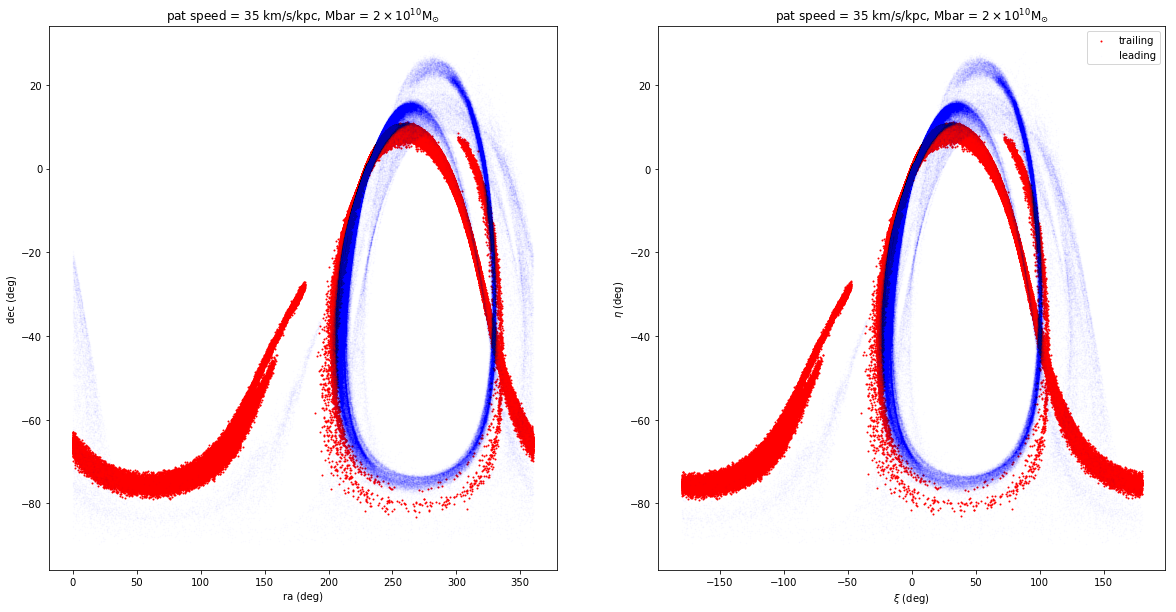

In [14]:
dir35_2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/2_1010Msun/trailing/'
ra_t2, dec_t2,ra_l2,dec_l2=process_sample(dir35_2,out_format='radec')
xi_t2,eta_t2,xi_l2,eta_l2=process_sample(dir35_2,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t2,dec_t2,s=1,c='r',label='trailing')
plt.scatter(ra_l2,dec_l2,s=1,c='b',label='leading',alpha=0.01)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $2\times 10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t2,eta_t2,s=1,c='r',label='trailing')
plt.scatter(xi_l2,eta_l2,s=1,c='b',label='leading',alpha=0.01)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $2\times 10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('5_109Msun_sky_coords.pdf',format='pdf')
plt.show()

In [ ]:
dir60='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed60/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir60,d='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir60,d='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing')
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading')
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('pat_speed = 60 km/s/kpc')

#plot xi, eta
plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing')
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading')
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title('pat_speed = 60 km/s/kpc')
plt.legend(loc='upper right')
plt.show()


986000
no of xi bins = 141


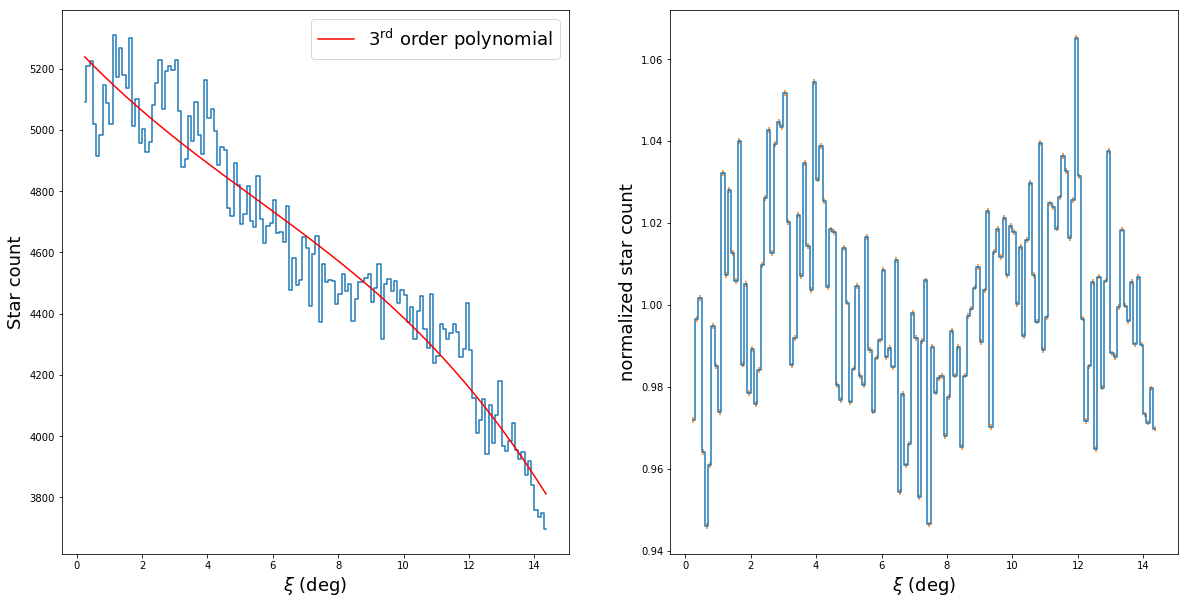

991000
no of xi bins = 141


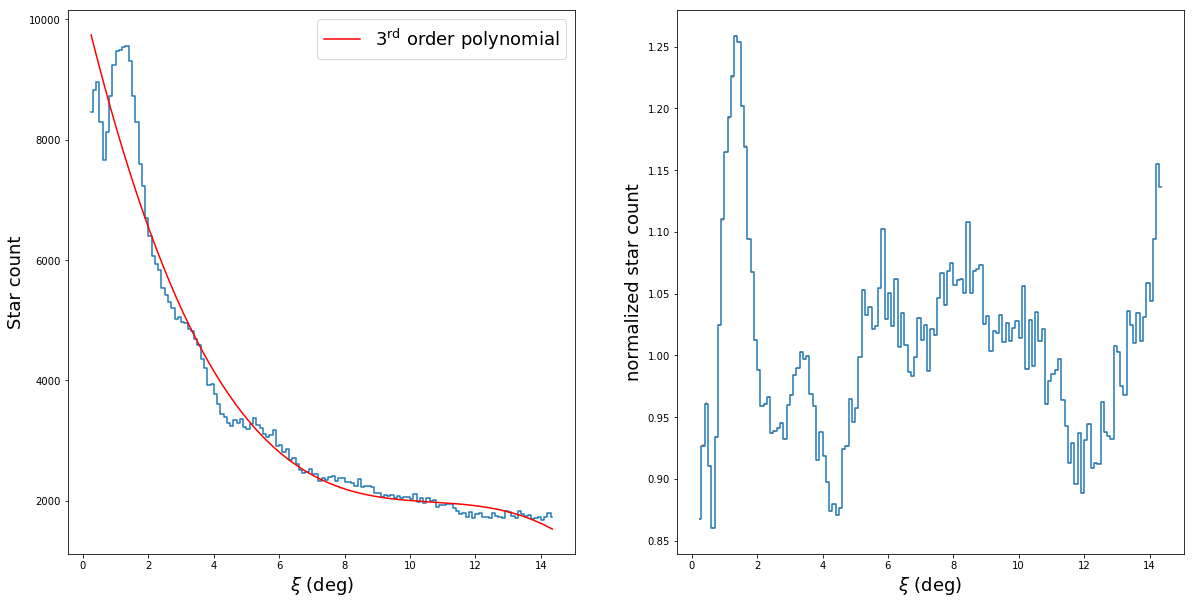

989000
no of xi bins = 141


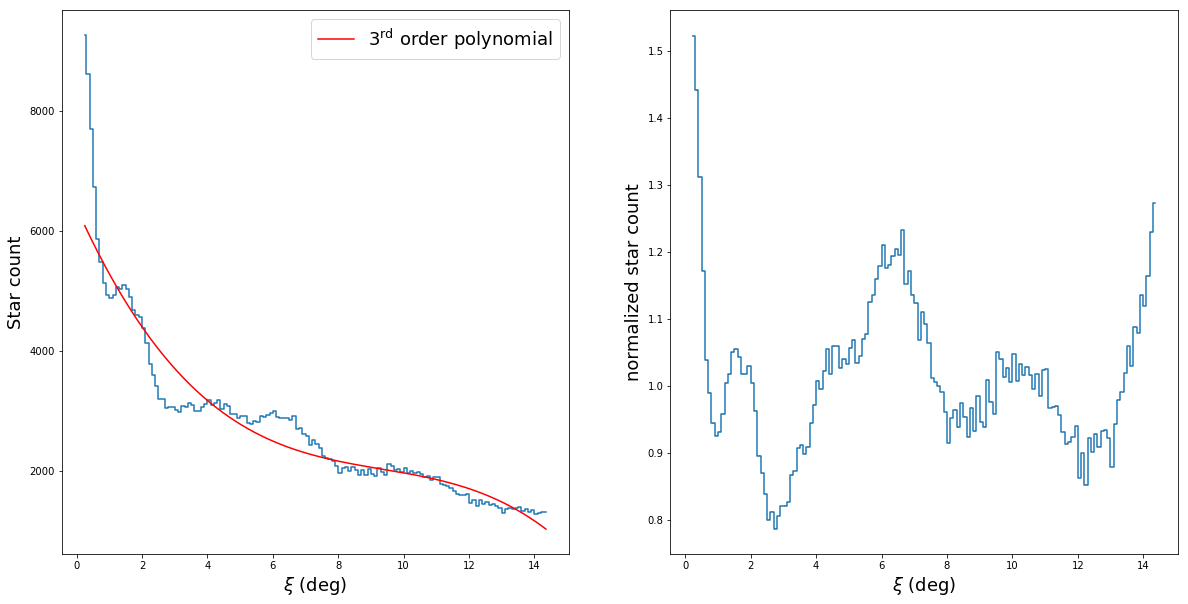

In [26]:
#compute density along xi and save 

midxi,nden,err = compute_ndenxi(xi_t,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar5_10_9_barspeed35_phi27_polydeg3.pdf')

midxi1,nden1,err1 = compute_ndenxi(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed35_phi27_polydeg3.pdf')

midxi2,nden2,err2 = compute_ndenxi(xi_t2,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar2_10_10barspeed35_phi27_polydeg3.pdf')


In [24]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar5_109_barphi27_patspeed35.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

outdir1 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'
fo1=open(outdir1 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden1)):
    fo1.write(str(midxi1[j]) + "   " + str(nden1[j]) + "   " + str(err1[j]) + "\n")
    
fo1.close()

outdir2 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/2_1010Msun/'
fo2=open(outdir2 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar2_1010_barphi27_patspeed35.dat','w')
fo2.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden2)):
    fo2.write(str(midxi2[j]) + "   " + str(nden2[j]) + "   " + str(err2[j]) + "\n")
    
fo2.close()

#fo1=open(outdir + 'Pal5_density_samples_polyfit2_trailing_SCFbarMbar10_10_barphi27_patspeed60.dat','w')
#fo1.write("#xi    den_contrast    shot_noise" + '\n')
#for jj in range(len(nden_poly1)):
#    fo1.write(str(midxi1[jj]) + "   " + str(nden_poly1[jj]) + "   " + str(err1[jj]) + "\n")
    
#fo1.close()

In [27]:
def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0]
    tdata=data[:,1]
    data_err=data[:,2]
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err




def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.01,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

In [28]:
filename='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/2_1010Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar2_1010_barphi27_patspeed35.dat'
filename1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed35.dat'
filename2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar5_109_barphi27_patspeed35.dat'

px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')
px2,py2,pyerr2=compute_Pk(filename2, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px,py,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $2\times 10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='r',zorder=1,ls='--')
loglog(px1,py1,color='k',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='k',zorder=1,ls='--')
loglog(px2,py2,color='g',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $5\times 10^{9} \ \rm{M}_{\odot}$')
loglog(px2,pyerr2,lw=2.,color='g',zorder=1,ls='--')
set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_only_trailing.pdf')



/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':



# include stars from both arms

986000 719


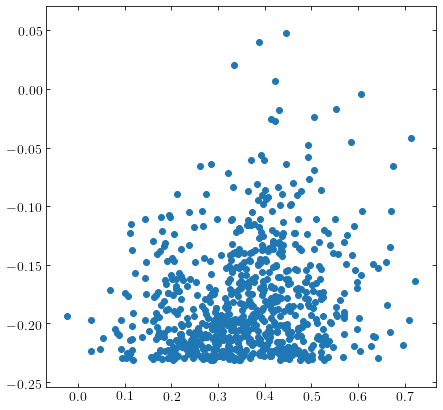

991000 907591


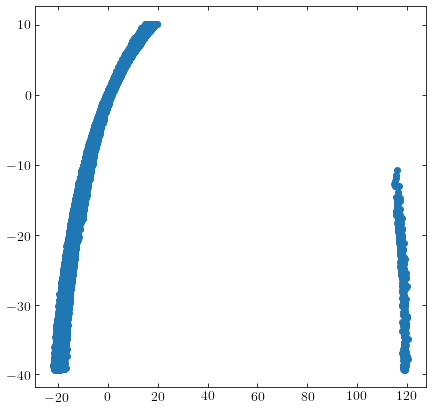

989000 935994


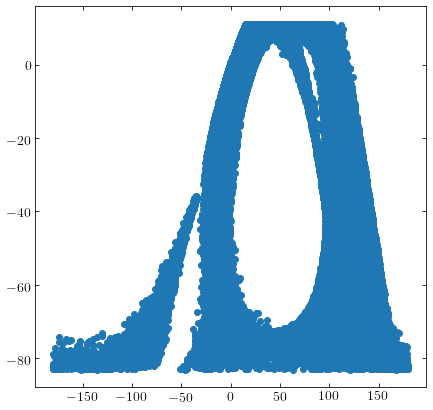

In [29]:
min_eta_t=min(eta_t)
max_eta_t=max(eta_t)

xi_l_select=[]
eta_l_select=[]

for jj in range(len(eta_l)):
    if min_eta_t <= eta_l[jj] <= max_eta_t :
        xi_l_select.append(xi_l[jj])
        eta_l_select.append(eta_l[jj])

print (len(xi_l), len(xi_l_select))

plt.figure()
plt.scatter(xi_l_select,eta_l_select)
plt.show()

min_eta_t1=min(eta_t1)
max_eta_t1=max(eta_t1)

xi_l_select1=[]
eta_l_select1=[]

for jj in range(len(eta_l1)):
    if min_eta_t1 <= eta_l1[jj] <= max_eta_t1 :
        xi_l_select1.append(xi_l1[jj])
        eta_l_select1.append(eta_l1[jj])

print (len(xi_l1), len(xi_l_select1))

plt.figure()
plt.scatter(xi_l_select1,eta_l_select1)
plt.show()

min_eta_t2=min(eta_t2)
max_eta_t2=max(eta_t2)

xi_l_select2=[]
eta_l_select2=[]

for jj in range(len(eta_l2)):
    if min_eta_t2 <= eta_l2[jj] <= max_eta_t2:
        xi_l_select2.append(xi_l2[jj])
        eta_l_select2.append(eta_l2[jj])

print (len(xi_l2), len(xi_l_select2))

plt.figure()
plt.scatter(xi_l_select2,eta_l_select2)
plt.show()

986719
no of xi bins = 141


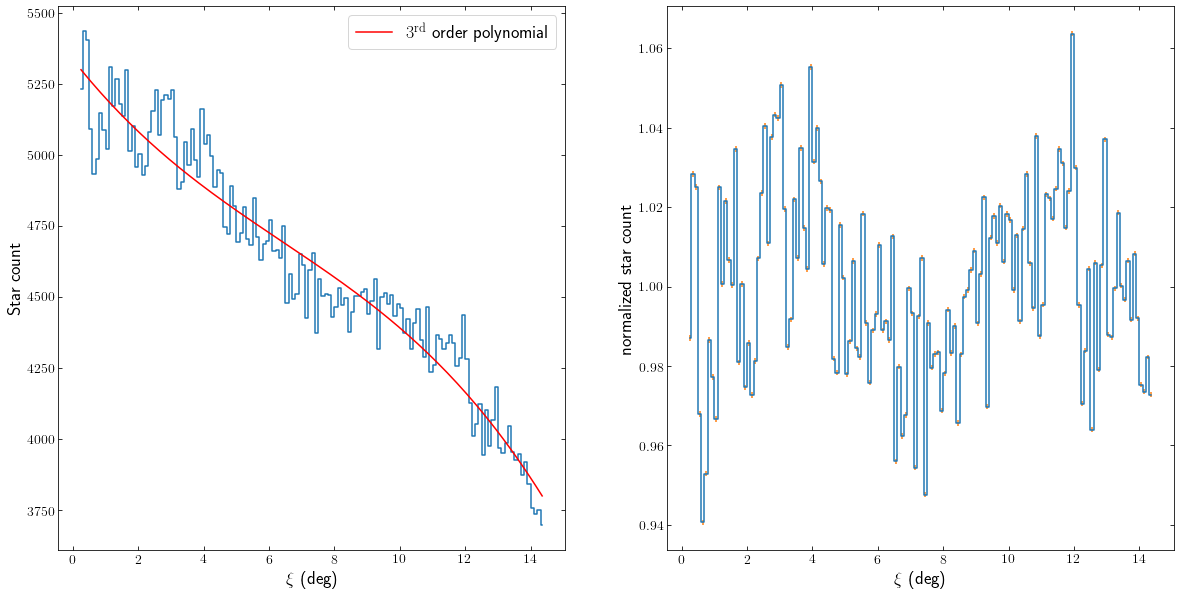

1898591
no of xi bins = 141


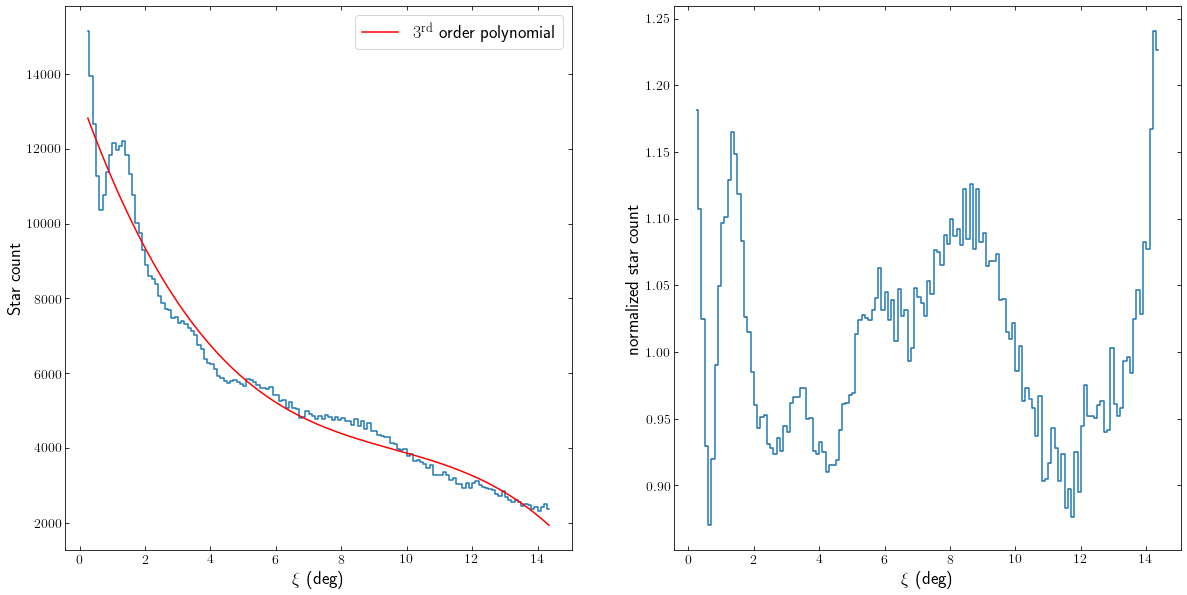

In [30]:
xi_all = np.concatenate((xi_t,xi_l_select))

midxi_all,nden_all,err_all = compute_ndenxi(xi_all,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar5_10_9_barspeed35_phi27_polydeg3.pdf')

xi_all1 = np.concatenate((xi_t1,xi_l_select1))

midxi_all1,nden_all1,err_all1 = compute_ndenxi(xi_all1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed35_phi27_polydeg3.pdf')

In [31]:
#write the mean density



outdir= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
fo_all=open(outdir + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar5_109_barphi27_patspeed35.dat','w')
fo_all.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all)):
    fo_all.write(str(midxi_all[j]) + "   " + str(nden_all[j]) + "   " + str(err_all[j]) + "\n")
    
fo_all.close()

outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'
fo_all1=open(outdir1 + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all1)):
    fo_all1.write(str(midxi_all1[jj]) + "   " + str(nden_all1[jj]) + "   " + str(err_all1[jj]) + "\n")
    
fo_all1.close()

In [32]:
outdir= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'

filename_all=outdir + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar5_109_barphi27_patspeed35.dat'
filename_all1=outdir1 + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar10_10_barphi27_patspeed35.dat'

px_all,py_all,pyerr_all=compute_Pk(filename_all, scaling = 'spectrum')
px_all1,py_all1,pyerr_all1=compute_Pk(filename_all1, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px_all,py_all,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $5\times 10^{9} \ \rm{M}_{\odot}$')
loglog(px_all,pyerr_all,lw=2.,color='r',zorder=1,ls='--')
loglog(px_all1,py_all1,color='k',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px_all1,pyerr_all1,lw=2.,color='k',zorder=1,ls='--')
set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_both_arms.pdf')


/home/nil/.local/share/canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in divide
  if __name__ == '__main__':



In [ ]:
else :
        nsample=numpy.sum(Ndn)
        smooth_sample=np.loadtxt('/home/nil/Dropbox/streamgap-pepper/smooth_Pal5_samples/Pal5_smooth_stream_all_samples_trailing_minxi0.2_maxxi14.4_noSCFbar.dat')[:,0]
        smooth_xi=smooth_sample[:nsample]
        Ndnsmooth=np.histogram(smooth_xi,xibin_edge)[0]
        nden=[float(Ndn[i])/float(Ndnsmooth[i]) for i in range(len(Ndn))]
                   
        if plot :
            plt.figure(figsize=(20,10))
            plt.plot(midxi,nden,ls='steps-mid')
            plt.errorbar(midxi,nden,err,marker='None',ls='None')
            plt.show()